#  Import Libraries :

In [4]:
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Conv1D, GlobalMaxPooling1D
# from generate_train_test_datasets import load_pickle, save_as_pickle, generate_text_graph
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix,classification_report
from keras.preprocessing.sequence import pad_sequences
# from evaluate_results import evaluate_model_results
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Dense, Reshape 
from concurrent.futures import ProcessPoolExecutor
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import Sequence
from keras.backend import clear_session
from keras.initializers import Constant
from nltk.tokenize import word_tokenize
from threading import current_thread
from argparse import ArgumentParser
from collections import OrderedDict
from keras.models import Sequential
from keras.models import load_model
from itertools import combinations
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from keras import backend as K
from functools import partial
import torch.optim as optim
from numpy import save,load
import concurrent.futures
from numpy import asarray
from keras import layers
# from models import gcn
from keras import Model
from tqdm import tqdm
import esprima as esp
from time import time
import torch.nn as nn
import networkx as nx
import seaborn as sb
import pandas as pd
import numpy as np
import logging
import gensim 
import random
import urllib
import pickle
import torch
import pydot
import math
import html
import nltk
import re
import os
import gc
np.random.seed(123)
plt.style.use('ggplot')

# Load and show data : 

In [5]:
# encoding='utf-8'
# encoding = "cp1252"
# encoding = "ISO-8859-1"

data_path = "C:\\Users\\user\\Python_Anaconda\\Tasks\\00_Extract hidden state from first LSTM layer\\On Payload_Data\\Main dataset"
df_xss = pd.read_csv(os.path.join(data_path,"xssed.csv"),  encoding = "ISO-8859-1")
df_normal = pd.read_csv(os.path.join(data_path,"normal_examples 1.csv"),  encoding = "ISO-8859-1")
df_xss.columns =['raw_data']
df_normal.columns =['raw_data']
print("df_xss : ",df_xss.shape)
print("df_normal : ",df_normal.shape)

df_xss.head()

df_xss :  (48508, 1)
df_normal :  (201086, 1)


,raw_data
0,symbol%3D%3Ch1%3E%3Cscript%3Ealert%28/hacked/%...
1,query%3D%3CIMG%2B%22%22%22%3E%3CSCRIPT%3Ealert...
2,ReturnUrl%3Dhttp%3A//www.elle.fr/recherche/rec...
3,_lang%3D%22%3E%3Cscript%3Ealert%28document.coo...
4,language%3D%22%3E%3C/script%3E%22%3E%27%3E%3Cs...


In [6]:
df_normal.head()

,raw_data
0,code%3Dzs_000001%2Czs_399001%2Czs_399006%26cb%...
1,_%3D1498591951848%26list%3Dml_sh600030
2,6053%26ri%3Dzb6-00f%7E-04gUry-01h-0RC%26tn%3D1...
3,b1498592370545%3D1
4,v%3D13111002


# Data processing : 

### 1 - Decode :

In [7]:
def Decode_Stage(x):
    x = urllib.parse.unquote(x)
    x = html.unescape(x)
    return x

In [8]:
df_xss['decode_data'] = df_xss['raw_data'].apply(Decode_Stage)
df_xss.head()

,raw_data,decode_data
0,symbol%3D%3Ch1%3E%3Cscript%3Ealert%28/hacked/%...,symbol=<h1><script>alert(/hacked/)</script></h...
1,query%3D%3CIMG%2B%22%22%22%3E%3CSCRIPT%3Ealert...,"query=<IMG+""""""><SCRIPT>alert(""cyb3r_pr3dat0r"")..."
2,ReturnUrl%3Dhttp%3A//www.elle.fr/recherche/rec...,ReturnUrl=http://www.elle.fr/recherche/recherc...
3,_lang%3D%22%3E%3Cscript%3Ealert%28document.coo...,"_lang=""><script>alert(document.cookie)</script>"
4,language%3D%22%3E%3C/script%3E%22%3E%27%3E%3Cs...,"language=""></script>"">'><script>alert(""Arman I..."


In [9]:
df_normal['decode_data'] = df_normal['raw_data'].apply(Decode_Stage)
df_normal.head()

,raw_data,decode_data
0,code%3Dzs_000001%2Czs_399001%2Czs_399006%26cb%...,"code=zs_000001,zs_399001,zs_399006&cb=fortune_..."
1,_%3D1498591951848%26list%3Dml_sh600030,_=1498591951848&list=ml_sh600030
2,6053%26ri%3Dzb6-00f%7E-04gUry-01h-0RC%26tn%3D1...,6053&ri=zb6-00f~-04gUry-01h-0RC&tn=1&en=4L9RAT...
3,b1498592370545%3D1,b1498592370545=1
4,v%3D13111002,v=13111002


### 2 - Generalization : 

In [10]:
def Generalization_Stage(x):
    x = x.lower()
    x, _ = re.subn(r'\d+', "0", x)
    x, _ = re.subn(r'(http|https)://[a-zA-Z0-9\.@/!&#\?]+',"http://u", x)
    return x

In [11]:
df_xss['Generalization_data'] = df_xss['decode_data'].apply(Generalization_Stage)
df_xss.head()

,raw_data,decode_data,Generalization_data
0,symbol%3D%3Ch1%3E%3Cscript%3Ealert%28/hacked/%...,symbol=<h1><script>alert(/hacked/)</script></h...,symbol=<h0><script>alert(/hacked/)</script></h...
1,query%3D%3CIMG%2B%22%22%22%3E%3CSCRIPT%3Ealert...,"query=<IMG+""""""><SCRIPT>alert(""cyb3r_pr3dat0r"")...","query=<img+""""""><script>alert(""cyb0r_pr0dat0r"")..."
2,ReturnUrl%3Dhttp%3A//www.elle.fr/recherche/rec...,ReturnUrl=http://www.elle.fr/recherche/recherc...,"returnurl=http://u-globale/(searchtext)/""/><sc..."
3,_lang%3D%22%3E%3Cscript%3Ealert%28document.coo...,"_lang=""><script>alert(document.cookie)</script>","_lang=""><script>alert(document.cookie)</script>"
4,language%3D%22%3E%3C/script%3E%22%3E%27%3E%3Cs...,"language=""></script>"">'><script>alert(""Arman I...","language=""></script>"">'><script>alert(""arman i..."


In [12]:
df_normal['Generalization_data'] = df_normal['decode_data'].apply(Generalization_Stage)
df_normal.head()

,raw_data,decode_data,Generalization_data
0,code%3Dzs_000001%2Czs_399001%2Czs_399006%26cb%...,"code=zs_000001,zs_399001,zs_399006&cb=fortune_...","code=zs_0,zs_0,zs_0&cb=fortune_hq_cn&_=0"
1,_%3D1498591951848%26list%3Dml_sh600030,_=1498591951848&list=ml_sh600030,_=0&list=ml_sh0
2,6053%26ri%3Dzb6-00f%7E-04gUry-01h-0RC%26tn%3D1...,6053&ri=zb6-00f~-04gUry-01h-0RC&tn=1&en=4L9RAT...,0&ri=zb0-0f~-0gury-0h-0rc&tn=0&en=0l0ratiswj0c...
3,b1498592370545%3D1,b1498592370545=1,b0=0
4,v%3D13111002,v=13111002,v=0


### 3 - Segmentation :

In [13]:
def Segmentation_Stage(x):
    seg = r'''(?x)[\w\.]+?\(|\)|"\w+?"|'\w+?'|http://\w|</\w+>|<\w+>|<\w+|\w+=|>|[\w\.]+/'''
    token = nltk.regexp_tokenize(x, seg)
    return token

In [14]:
df_xss['Segmentation_data'] = df_xss['Generalization_data'].apply(Segmentation_Stage)
df_xss.head()

,raw_data,decode_data,Generalization_data,Segmentation_data
0,symbol%3D%3Ch1%3E%3Cscript%3Ealert%28/hacked/%...,symbol=<h1><script>alert(/hacked/)</script></h...,symbol=<h0><script>alert(/hacked/)</script></h...,"[symbol=, <h0>, <script>, alert(, hacked/, ), ..."
1,query%3D%3CIMG%2B%22%22%22%3E%3CSCRIPT%3Ealert...,"query=<IMG+""""""><SCRIPT>alert(""cyb3r_pr3dat0r"")...","query=<img+""""""><script>alert(""cyb0r_pr0dat0r"")...","[query=, <img, >, <script>, alert(, ""cyb0r_pr0..."
2,ReturnUrl%3Dhttp%3A//www.elle.fr/recherche/rec...,ReturnUrl=http://www.elle.fr/recherche/recherc...,"returnurl=http://u-globale/(searchtext)/""/><sc...","[returnurl=, http://u, globale/, ), >, <script..."
3,_lang%3D%22%3E%3Cscript%3Ealert%28document.coo...,"_lang=""><script>alert(document.cookie)</script>","_lang=""><script>alert(document.cookie)</script>","[_lang=, >, <script>, alert(, ), </script>]"
4,language%3D%22%3E%3C/script%3E%22%3E%27%3E%3Cs...,"language=""></script>"">'><script>alert(""Arman I...","language=""></script>"">'><script>alert(""arman i...","[language=, >, </script>, >, >, <script>, aler..."


In [15]:
df_normal['Segmentation_data'] = df_normal['Generalization_data'].apply(Segmentation_Stage)
df_normal.head()

,raw_data,decode_data,Generalization_data,Segmentation_data
0,code%3Dzs_000001%2Czs_399001%2Czs_399006%26cb%...,"code=zs_000001,zs_399001,zs_399006&cb=fortune_...","code=zs_0,zs_0,zs_0&cb=fortune_hq_cn&_=0","[code=, cb=, _=]"
1,_%3D1498591951848%26list%3Dml_sh600030,_=1498591951848&list=ml_sh600030,_=0&list=ml_sh0,"[_=, list=]"
2,6053%26ri%3Dzb6-00f%7E-04gUry-01h-0RC%26tn%3D1...,6053&ri=zb6-00f~-04gUry-01h-0RC&tn=1&en=4L9RAT...,0&ri=zb0-0f~-0gury-0h-0rc&tn=0&en=0l0ratiswj0c...,"[ri=, tn=, en=, >, >]"
3,b1498592370545%3D1,b1498592370545=1,b0=0,[b0=]
4,v%3D13111002,v=13111002,v=0,[v=]


# Build graph structure

In [16]:
def dummy_fun(doc):
    return doc

In [17]:
df_xss_ = df_xss.sample(1000)

In [38]:
### Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(input="content", max_features=None, tokenizer=dummy_fun, preprocessor=dummy_fun)
vectorizer.fit(df_xss_["Segmentation_data"])
df_tfidf = vectorizer.transform(df_xss_["Segmentation_data"])
df_tfidf = df_tfidf.toarray()
vocab = vectorizer.get_feature_names()
vocab = np.array(vocab)
df_tfidf = pd.DataFrame(df_tfidf,columns=vocab)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [43]:
vocab[100:1000]

array(['</dd>', '</details>', '</div>', '</dt>', '</element>', '</embed>',
       '</emuseum_search>', '</figure>', '</font>', '</footer>',
       '</form>', '</frame>', '</h0>', '</head>', '</header>',
       '</hgroup>', '</html>', '</ifram>', '</iframe>', '</image>',
       '</img>', '</kbd>', '</keygen>', '</label>', '</legend>',
       '</link>', '</map>', '</marquee>', '</menu>', '</meta>',
       '</meter>', '</noembed>', '</noframes>', '</noscript>',
       '</object>', '</ol>', '</optgroup>', '</option>', '</output>',
       '</param>', '</picture>', '</plaintext>', '</pre>', '</progress>',
       '</q>', '</rp>', '</rt>', '</rtc>', '</ruby>', '</s>', '</samp>',
       '</script>', '</section>', '</select>', '</shadow>', '</slot>',
       '</small>', '</source>', '</spacer>', '</span>', '</strike>',
       '</strong>', '</style>', '</sub>', '</sup>', '</svg>', '</table>',
       '</tbody>', '</td>', '</template>', '</textarea>', '</tfoot>',
       '</th>', '</thead>', '</time>

In [46]:
vectorizer.vocabulary_

{'p=': 973,
 'ts=': 1345,
 'w=': 1391,
 '</script>': 151,
 '<script>': 270,
 'alert(': 339,
 'ass/': 371,
 ')': 70,
 'x=': 1411,
 'y=': 1417,
 'styl=': 1270,
 'bysweb/': 420,
 'theme/': 1315,
 'tur=': 1350,
 'id=': 716,
 'dznno=': 569,
 'alan=': 338,
 'nitelikno=': 866,
 '>': 306,
 '<script': 269,
 'turkey/': 1351,
 '<h0>': 224,
 '</h0>': 112,
 '<applet': 188,
 'onpointermove=': 950,
 '</applet>': 81,
 'q=': 1051,
 'xssed/': 1415,
 'z=': 1424,
 '<progress': 261,
 'oncopy=': 920,
 '</progress>': 143,
 'lang=': 773,
 'page=': 975,
 'enq_id=': 586,
 '</title>': 175,
 '<marquee>': 240,
 '</marquee>': 127,
 'bbs=': 389,
 'ds=': 567,
 'qu=': 1057,
 '"xss"': 42,
 's=': 1116,
 '<img': 231,
 'onmouseover=': 944,
 '</img>': 120,
 'f=': 615,
 '<shadow': 274,
 'onmousedown=': 939,
 '</shadow>': 154,
 '<canvas': 199,
 'tabindex=': 1293,
 'onbeforedeactivate=': 913,
 '</canvas>': 90,
 '<input': 232,
 '<style>': 283,
 '</style>': 162,
 '<a': 183,
 'style=': 1271,
 'onanimationiteration=': 908,
 '</a>

In [19]:
print(df_tfidf.shape)
df_tfidf.head()

(1000, 1432)


,"""0""","""0x0a""","""a""","""akincilar""","""always""","""backdoor""","""bluemax""","""casper""","""coll0er""","""courier""",...,yer=,ytoxontpoja0czo0odoiahr0cdovlycikckmjte0aw0nihnyyz0iahr0cdovl0d0dy0izw0rag0eweuy0tl0ltywdlcy0vd0zzceuz0lmij0io0=,z=,zc=,zeryus/,zip=,zipcode=,zone=,zoneid=,zoom_query=
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.482422,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
### PMI between words
window = 10 # sliding window size to calculate point-wise mutual information between words
names = vocab
n_i  = OrderedDict((name, 0) for name in names)
word2index = OrderedDict( (name,index) for index,name in enumerate(names) )
occurrences = np.zeros( (len(names),len(names)) ,dtype=np.int32)

# Find the co-occurrences:
no_windows = 0
for l in tqdm(df_xss_["Segmentation_data"], total=len(df_xss_["Segmentation_data"])):
    for i in range(len(l)-window):
        no_windows += 1
        d = set(l[i:(i+window)])

        for w in d:
            n_i[w] += 1
        for w1,w2 in combinations(d,2):
            i1 = word2index[w1]
            i2 = word2index[w2]

            occurrences[i1][i2] += 1
            occurrences[i2][i1] += 1


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10894.49it/s]


In [21]:
## convert to PMI
p_ij = pd.DataFrame(occurrences, index = names,columns=names)/no_windows
p_i = pd.Series(n_i, index=n_i.keys())/no_windows

for col in p_ij.columns:
    p_ij[col] = p_ij[col]/p_i[col]
for row in p_ij.index:
    p_ij.loc[row,:] = p_ij.loc[row,:]/p_i[row]
p_ij = p_ij + 1E-9
for col in p_ij.columns:
    p_ij[col] = p_ij[col].apply(lambda x: math.log(x))

In [23]:
def nCr(n,r):
    f = math.factorial
    return int(f(n)/(f(r)*f(n-r)))

In [95]:
def word_word_edges(p_ij):
    word_word = []
    cols = list(p_ij.columns); cols = [str(w) for w in cols]
    for w1, w2 in tqdm(combinations(cols, 2), total=nCr(len(cols), 2)):
        if (p_ij.loc[w1,w2] > 0):
            word_word.append((w1,w2,{"weight":p_ij.loc[w1,w2]}))
    return word_word
    
### Build graph
G = nx.Graph()
G.add_nodes_from(df_tfidf.index) ## document nodes df_xss_["Segmentation_data"]
G.add_nodes_from(vocab) ## word nodes
### build edges between document-word pairs
document_word = [(doc,w,{"weight":df_tfidf.loc[doc,w]}) for doc in df_tfidf.index for w in df_tfidf.columns]
G.add_edges_from(document_word)
### build edges between word-word pairs
word_word = word_word_edges(p_ij)
G.add_edges_from(word_word)

100%|████████████████████████████████████████████████████████████████████| 1024596/1024596 [00:09<00:00, 113197.24it/s]


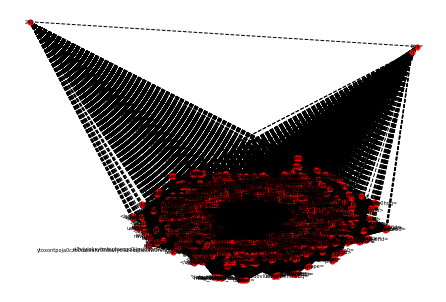

In [110]:
#Plot the graph
nx.draw(G,pos=nx.spring_layout(G), with_labels=True, font_weight='normal',font_size=5,style='dashed',
       node_size=30,node_color='#F30808',linewidths=0.5,vmin=10,vmax=10000)
plt.show()

In [80]:
A = nx.to_numpy_matrix(G, weight="weight"); A = A + np.eye(G.number_of_nodes())
A

In [81]:
degrees = []
for d in G.degree(weight=None):
    if d == 0:
        degrees.append(0)
    else:
        degrees.append(d[1]**(-0.5))
degrees = np.diag(degrees)
X = np.eye(G.number_of_nodes()) # Features are just identity matrix

In [82]:
A_hat = degrees@A@degrees

In [83]:
AX = np.dot(A,X)
print("Dot product of A and X (AX):\n", AX)

Dot product of A and X (AX):
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [84]:
G_self_loops = G.copy()

self_loops = []
for i in range(G.number_of_nodes()):
    self_loops.append((i,i))

G_self_loops.add_edges_from(self_loops)

#Check the edges of G_self_loops after adding the self loops
print('Edges of G with self-loops:\n', G_self_loops.edges)

#Get the Adjacency Matrix (A) and Node Features Matrix (X) of added self-lopps graph
# A_hat = np.array(nx.attr_matrix(G_self_loops, weight="weight")[0])
print('Adjacency Matrix of added self-loops G (A_hat):\n', A_hat)

#Calculate the dot product of A_hat and X (AX)
AX = np.dot(A_hat, X)
print('AX:\n', AX)

Edges of G with self-loops:
 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



AX:
 [[0.00069832 0.         0.         ... 0.         0.         0.        ]
 [0.         0.00069832 0.         ... 0.         0.         0.        ]
 [0.         0.         0.00069832 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.001      0.         0.        ]
 [0.         0.         0.         ... 0.         0.001      0.        ]
 [0.         0.         0.         ... 0.         0.         0.00099206]]


In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class gcn(nn.Module):
    def __init__(self, X_size, A_hat, bias=True): # X_size = num features
        super(gcn, self).__init__()
        self.A_hat = torch.tensor(A_hat, requires_grad=False).float()
        self.weight = nn.parameter.Parameter(torch.FloatTensor(X_size, 330))
        var = 2./(self.weight.size(1)+self.weight.size(0))
        self.weight.data.normal_(0,var)
        self.weight2 = nn.parameter.Parameter(torch.FloatTensor(330, 130))
        var2 = 2./(self.weight2.size(1)+self.weight2.size(0))
        self.weight2.data.normal_(0,var2)
        if bias:
            self.bias = nn.parameter.Parameter(torch.FloatTensor(330))
            self.bias.data.normal_(0,var)
            self.bias2 = nn.parameter.Parameter(torch.FloatTensor(130))
            self.bias2.data.normal_(0,var2)
        else:
            self.register_parameter("bias", None)
        self.fc1 = nn.Linear(130,66)
        
    def forward(self, X): ### 2-layer GCN architecture
        X = torch.mm(X, self.weight)
        if self.bias is not None:
            X = (X + self.bias)
        X = F.relu(torch.mm(self.A_hat, X))
        X = torch.mm(X, self.weight2)
        if self.bias2 is not None:
            X = (X + self.bias2)
        X = F.relu(torch.mm(self.A_hat, X))
        return self.fc1(X)

In [91]:
# parser = ArgumentParser()
# parser.add_argument("--hidden_size_1", type=int, default=330, help="Size of first GCN hidden weights")
# parser.add_argument("--hidden_size_2", type=int, default=130, help="Size of second GCN hidden weights")
# parser.add_argument("--num_classes", type=int, default=66, help="Number of prediction classes")
# parser.add_argument("--test_ratio", type=float, default=0.1, help="Ratio of test to training nodes")
# parser.add_argument("--num_epochs", type=int, default=3300, help="No of epochs")
# parser.add_argument("--lr", type=float, default=0.011, help="learning rate")
# parser.add_argument("--model_no", type=int, default=0, help="Model ID")
#     args = parser.parse_args()
# net = gcn(xss_.shape[1], A_hat, args)

In [92]:
gg = gcn(df_xss_.shape[0], A_hat, bias=True)

In [89]:
gg.forward(df_xss_['Generalization_data'])

TypeError: mm(): argument 'input' (position 1) must be Tensor, not list

In [ ]:
net = gcn(X.shape[1], A_hat, args)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=args.lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1000,2000,3000,4000,5000,6000], gamma=0.77)

start_epoch, best_pred = load_state(net, optimizer, scheduler, model_no=args.model_no, load_best=True)
losses_per_epoch, evaluation_untrained = load_results(model_no=args.model_no)

logger.info("Starting training process...")
net.train()
evaluation_trained = []
for e in range(start_epoch, args.num_epochs):
    optimizer.zero_grad()
    output = net(f)
    loss = criterion(output[selected], torch.tensor(labels_selected).long() -1)
    losses_per_epoch.append(loss.item())
    loss.backward()
    optimizer.step()
    if e % 50 == 0:
        ### Evaluate other untrained nodes and check accuracy of labelling
        net.eval()
        with torch.no_grad():
            pred_labels = net(f)
            trained_accuracy = evaluate(output[selected], labels_selected); untrained_accuracy = evaluate(pred_labels[test_idxs], labels_not_selected)
        evaluation_trained.append((e, trained_accuracy)); evaluation_untrained.append((e, untrained_accuracy))
        print("[Epoch %d]: Evaluation accuracy of trained nodes: %.7f" % (e, trained_accuracy))
        print("[Epoch %d]: Evaluation accuracy of test nodes: %.7f" % (e, untrained_accuracy))
        print("Labels of trained nodes: \n", output[selected].max(1)[1])
        net.train()
        if trained_accuracy > best_pred:
            best_pred = trained_accuracy
            torch.save({
                'epoch': e + 1,\
                'state_dict': net.state_dict(),\
                'best_acc': trained_accuracy,\
                'optimizer' : optimizer.state_dict(),\
                'scheduler' : scheduler.state_dict(),\
            }, os.path.join("./data/" ,\
                "test_model_best_%d.pth.tar" % args.model_no))
    if (e % 250) == 0:
        save_as_pickle("test_losses_per_epoch_%d.pkl" % args.model_no, losses_per_epoch)
        save_as_pickle("test_accuracy_per_epoch_%d.pkl" % args.model_no, evaluation_untrained)
        torch.save({
                'epoch': e + 1,\
                'state_dict': net.state_dict(),\
                'best_acc': trained_accuracy,\
                'optimizer' : optimizer.state_dict(),\
                'scheduler' : scheduler.state_dict(),\
            }, os.path.join("./data/",\
                "test_checkpoint_%d.pth.tar" % args.model_no))
    scheduler.step()

logger.info("Finished training!")
evaluation_trained = np.array(evaluation_trained); evaluation_untrained = np.array(evaluation_untrained)
save_as_pickle("test_losses_per_epoch_%d_final.pkl" % args.model_no, losses_per_epoch)
save_as_pickle("train_accuracy_per_epoch_%d_final.pkl" % args.model_no, evaluation_trained)
save_as_pickle("test_accuracy_per_epoch_%d_final.pkl" % args.model_no, evaluation_untrained)

fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111)
ax.scatter([i for i in range(len(losses_per_epoch))], losses_per_epoch)
ax.set_xlabel("Epoch", fontsize=15)
ax.set_ylabel("Loss", fontsize=15)
ax.set_title("Loss vs Epoch", fontsize=20)
plt.savefig(os.path.join("./data/", "loss_vs_epoch.png"))

fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111)
ax.scatter(evaluation_trained[:,0], evaluation_trained[:,1])
ax.set_xlabel("Epoch", fontsize=15)
ax.set_ylabel("Accuracy on trained nodes", fontsize=15)
ax.set_title("Accuracy (trained nodes) vs Epoch", fontsize=20)
plt.savefig(os.path.join("./data/", "trained_accuracy_vs_epoch.png"))

fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111)
ax.scatter(evaluation_untrained[:,0], evaluation_untrained[:,1])
ax.set_xlabel("Epoch", fontsize=15)
ax.set_ylabel("Accuracy on untrained nodes", fontsize=15)
ax.set_title("Accuracy (untrained nodes) vs Epoch", fontsize=20)
plt.savefig(os.path.join("./data/", "untrained_accuracy_vs_epoch.png"))

fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111)
ax.scatter(evaluation_trained[:,0], evaluation_trained[:,1], c="red", marker="v", \
           label="Trained Nodes")
ax.scatter(evaluation_untrained[:,0], evaluation_untrained[:,1], c="blue", marker="o",\
           label="Untrained Nodes")
ax.set_xlabel("Epoch", fontsize=15)
ax.set_ylabel("Accuracy", fontsize=15)
ax.set_title("Accuracy vs Epoch", fontsize=20)
ax.legend(fontsize=20)
plt.savefig(os.path.join("./data/", "combined_plot_accuracy_vs_epoch.png"))

logger.info("Evaluate results...")
evaluate_model_results(args=args)